### Imports

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy import plotting
import subjects

### Epoch file for interruptions caught by Piezo in lfp channel

In [3]:
sessions = subjects.sd.ratVday2

for s, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    period = [post[0], post[0] + 5 * 3600]
    piezo_signal = sess.eegfile.get_signal(256, *period)
    zsc_signal = stats.zscore(piezo_signal.traces[0])
    piezo_binary = np.where(zsc_signal > 2, 1, 0)

    handling_epochs = sess.paradigm.from_boolean_array(piezo_binary, piezo_signal.time)
    handling_epochs = handling_epochs.set_labels("handling")
    # handling_epochs.save(sess.filePrefix.with_suffix(".handling"))

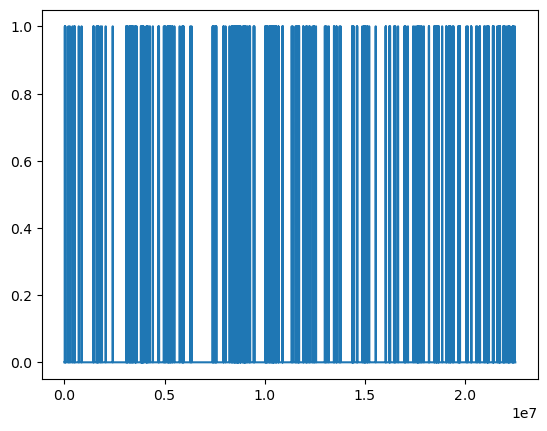

In [4]:
_, ax = plt.subplots()

ax.plot(piezo_binary)

### Epoch file for interruptions recorded by Piezo in TTL folder

In [5]:
from neuropy.io.openephysio import load_ttl_events

sessions = subjects.sd.ratUday1

for s, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    sd_start = post[0]

    folder = sess.filePrefix.parent / "handling"
    data = load_ttl_events(folder, sync_info=False)
    piezo_frames = data["timestamps"]
    piezo_time = piezo_frames / 30000

    recording_timestamps = np.load(folder / "timestamps_rec.npy", mmap_mode="r")
    sd_rec_start = recording_timestamps[0] / 30000

    piezo_actual_time = sd_start + piezo_time - sd_rec_start

    handling_epochs = sess.paradigm.from_array(
        piezo_actual_time[::2], piezo_actual_time[1::2], "handling"
    )

    # handling_epochs.save(sess.filePrefix.with_suffix(".handling"))

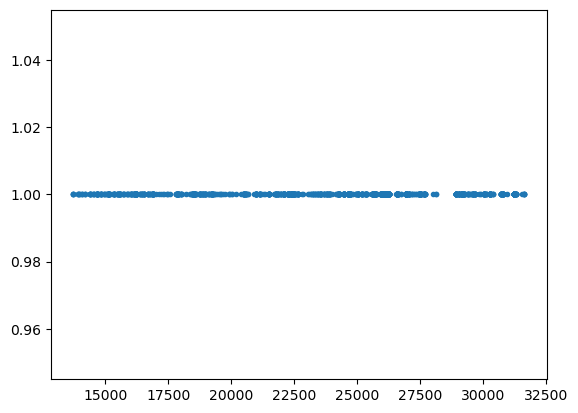

In [6]:
_, ax = plt.subplots()

# ax.plot(piezo_actual_time, np.ones_like(piezo_actual_time), ".")
ax.plot(handling_epochs.starts, np.ones(len(handling_epochs)), ".")

### Histrogram of interruptions

In [8]:
sessions = subjects.sd.ratUday1 + subjects.sd.ratUday4 + subjects.sd.ratVday2
sesh_day_labels = ("RatU Day1", "RatU Day8", "RatV Day3")  # Number by absolute day, 1 = first recording day.

handle_df = []
for s, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()

    # windows = np.linspace(post[0], post[0] + 5 * 3600, 3)
    starts = np.array([post[0], post[0] + 3 * 3600])
    stops = starts + 2 * 3600
    sd_epochs = sess.paradigm.from_array(starts, stops, ["0-2", "3-5"])

    duration = []
    for e in sd_epochs.itertuples():
        df = pd.DataFrame(
            {
                "duration": [sess.handling.time_slice(e.start, e.stop).durations.sum()],
                "counts": [sess.handling.time_slice(e.start, e.stop).n_epochs],
                "zt": e.label,
                "session": s,
                "grp": sess.tag,
            }
        )
        handle_df.append(df)

handle_df = pd.concat(handle_df, ignore_index=True)

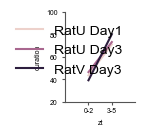

In [9]:
fig = subjects.SdFig().fig1(8, 8)
# sns.lineplot(data=handle_df, x="zt", y="counts", style="session",ax=axs[0])
ax = fig.subplot(fig.gs[0])
sns.lineplot(data=handle_df, x="zt", y="duration", hue="session", ax=ax)
ax.legend(sesh_day_labels, frameon=False)
ax.set_xlim(-1, 2)
ax.set_ylim(20, 100)

fig.savefig(subjects.figpath_sd / "handling", format="svg")

### Interruptions by hour, animals labeled.

In [15]:
sessions = subjects.sd.ratUday1 + subjects.sd.ratUday4 + subjects.sd.ratVday2
sesh_day_labels = ("RatU Day1", "RatU Day3", "RatV Day3")

handle_df_1h = []
for s, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()

    starts = post[0] + np.array([0, 1, 2, 3, 4]) * 3600
    stops = post[0] + np.array([1, 2, 3, 4, 5]) * 3600
    sd_epochs = sess.paradigm.from_array(starts, stops, ["0-1", "1-2", "2-3", "3-4", "4-5"])

    duration = []
    for e in sd_epochs.itertuples():
        df = pd.DataFrame(
            {
                "duration": [sess.handling.time_slice(e.start, e.stop).durations.sum()],
                "counts": [sess.handling.time_slice(e.start, e.stop).n_epochs],
                "zt": e.label,
                "session": s,
                "grp": sess.tag,
            }
        )
        handle_df_1h.append(df)

handle_df_1h = pd.concat(handle_df_1h, ignore_index=True)

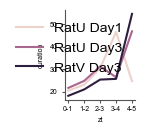

In [17]:
fig = subjects.SdFig().fig1(8, 8)
# sns.lineplot(data=handle_df, x="zt", y="counts", style="session",ax=axs[0])
ax = fig.subplot(fig.gs[0])
sns.lineplot(data=handle_df_1h, x="zt", y="duration", hue="session", ax=ax)
ax.legend(sesh_day_labels, frameon=False)
# ax.set_xlim(-1, 2)
# ax.set_ylim(20, 100)

fig.savefig(subjects.figpath_sd / "handling_1h_blocks", format="svg")

### Number/Rate of ripples before and after interruptions

In [84]:
sessions = subjects.sd.handling_data_sess
time_buffer = (-75, 75)

rpl_df, rpl_rate = [], []
rpl_rate_whole, rpl_rate_handling = [], []
for s, sess in enumerate(sessions):
    rpls = sess.ripple
    handling = sess.handling
    bins, binsize = np.linspace(time_buffer[0], time_buffer[1], np.sum(np.abs(time_buffer)) + 1, retstep=True)
    counts = np.array([np.histogram(rpls.starts, bins + t)[0] for t in handling.starts])
    total_counts = counts.sum(axis=0)

    rate = total_counts / (binsize * len(handling))

    rpl_rate.append(rate)
    df = pd.DataFrame(
        {"bins": bins[:-1] + binsize / 2, "counts": total_counts, "rate": rate, "session": s}
    )
    rpl_df.append(df)

    # Calculate mean ripple rates from whole session and from handling epochs only
    bin_size_whole = 5
    bins_whole_sesh = np.arange(0, sess.eegfile.duration, bin_size_whole)
    counts_whole_sesh = np.histogram(rpls.starts, bins_whole_sesh)[0]
    rate_whole_sesh = np.mean(counts_whole_sesh / bin_size_whole)
    rpl_rate_whole.append(rate_whole_sesh)
    
    bins_handling = np.arange(handling.starts.min(), handling.starts.max(), bin_size_whole)
    counts_handling = np.histogram(rpls.starts, bins_handling)[0]
    rate_handling = np.mean(counts_handling / bin_size_whole)
    rpl_rate_handling.append(rate_handling)

rpl_df = pd.concat(rpl_df, ignore_index=True)

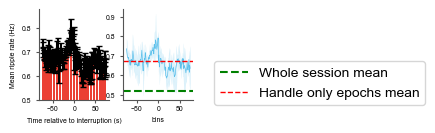

In [86]:
# _, ax = plt.subplots()

fig = subjects.SdFig().fig1(8, 8)
ax = fig.subplot(fig.gs[0])
# sns.lineplot(data=rpl_df, x="bins", y="rate", ci=None)
rpl_rate = np.vstack(rpl_rate)
mean_count = rpl_rate.mean(axis=0)
std_count = rpl_rate.std(axis=0) / np.sqrt(rpl_rate.shape[0])

ax.bar(
    bins[:-1] + binsize / 2,
    rpl_rate.mean(axis=0),
    yerr=std_count,
    # error_kw=dict(capsize=2),
    capsize=2,
    color=subjects.colors_sd(1)[1],
)

ax.set_ylim(0.5)

ax.set_xlabel("Time relative to interruption (s)")
ax.set_ylabel("Mean ripple rate (Hz)")

ax = fig.subplot(fig.gs[0,1])
# sns.lineplot(data=rpl_df, x="bins", y="rate", ci=None)
rpl_rate = np.vstack(rpl_rate)
mean_count = rpl_rate.mean(axis=0)
std_count = rpl_rate.std(axis=0) / np.sqrt(rpl_rate.shape[0])

sns.lineplot(data=rpl_df, x="bins", y="rate", linewidth=0.5, err_kws={"linewidth":0.1}, ax=ax)
# hm = ax.axhline(rpl_rate.reshape(-1).mean(), color='r', linestyle='--')
hwhole = ax.axhline(np.mean(rpl_rate_whole), color='g', linestyle='--')
hhandle = ax.axhline(np.mean(rpl_rate_handling), color='r', linestyle='--', linewidth=1)
ax.legend((hwhole, hhandle), ('Whole session mean', 'Handle only epochs mean'), bbox_to_anchor=(1.2, 0.5))
fig.savefig(subjects.figpath_sd / "handling_rpl_rate", format="svg")

### MUA/frate activity around interruptions

In [ ]:
sessions = subjects.sd.handling_data_sess

bin_size = 1

pyr_frate, inter_frate = [], []
for s, sess in enumerate(sessions):
    # mua = sess.mua
    neurons = sess.neurons_stable.get_neuron_type(["pyr", "inter"])
    handling = sess.handling
    psths = neurons.get_psth(handling.starts, bin_size=bin_size, n_bins=5, n_jobs=6)
    psths_frate = psths.sum(axis=2) / (len(handling) * bin_size)

    pyr_frate.append(psths_frate[neurons.neuron_type == "pyr", :])
    inter_frate.append(psths_frate[neurons.neuron_type == "inter", :])

pyr_frate = np.vstack(pyr_frate)
inter_frate = np.vstack(inter_frate)

In [ ]:
fig = subjects.SdFig().fig1(8, 8)
ax = fig.subplot(fig.gs[0])
time = np.linspace(-5, 5, 11)[:-1] + bin_size / 2

pyr_frate_mean = pyr_frate.mean(axis=0)
pyr_frate_sem = pyr_frate.std(axis=0) / np.sqrt(pyr_frate.shape[0])
inter_frate_mean = inter_frate.mean(axis=0)
inter_frate_sem = inter_frate.std(axis=0) / np.sqrt(inter_frate.shape[0])

error_kw = dict(
    capsize=1.2,
    marker="o",
    markersize=3,
    ecolor="k",
    elinewidth=0.5,
    lw=0.8,
    capthick=0.5,
)
ax.errorbar(time, pyr_frate_mean, yerr=pyr_frate_sem, color="r", **error_kw)
ax.set_xticks([-4, -2, 0, 2, 4])
ax.set_ylim(0.5, 1.5)

ax2 = fig.subplot(fig.gs[1])
ax2.errorbar(time, inter_frate_mean, yerr=inter_frate_sem, color="r", **error_kw)
ax2.set_xticks([-4, -2, 0, 2, 4])
ax2.set_ylim(10, 30)
# ax.plot(inter_frate.mean(axis=0))

fig.savefig(subjects.figpath_sd / "handling_frate", format="svg")

### Delta wave rate around interruptions
Could be interesting - rate seems to slowly ramp up over minutes prior to an interruption, much slower than ripple rate.

In [19]:
# Calculate
sessions = subjects.sd.handling_data_sess
time_buffer = (-75, 75)

delta_df, delta_rate = [], []
delta_rate_whole, delta_rate_handling = [], []
for s, sess in enumerate(sessions):
    delta = sess.delta_wave
    handling = sess.handling
    bins, binsize = np.linspace(time_buffer[0], time_buffer[1], np.sum(np.abs(time_buffer)) + 1, retstep=True)
    counts = np.array([np.histogram(delta.starts, bins + t)[0] for t in handling.starts])
    total_counts = counts.sum(axis=0)

    rate = total_counts / (binsize * len(handling))

    delta_rate.append(rate)
    df = pd.DataFrame(
        {"bins": bins[:-1] + binsize / 2, "counts": total_counts, "rate": rate, "session": s}
    )
    delta_df.append(df)

    # Calculate mean ripple rates from whole session and from handling epochs only
    bin_size_whole = 5
    bins_whole_sesh = np.arange(0, sess.eegfile.duration, bin_size_whole)
    counts_whole_sesh = np.histogram(delta.starts, bins_whole_sesh)[0]
    rate_whole_sesh = np.mean(counts_whole_sesh / bin_size_whole)
    delta_rate_whole.append(rate_whole_sesh)
    
    bins_handling = np.arange(handling.starts.min(), handling.starts.max(), bin_size_whole)
    counts_handling = np.histogram(delta.starts, bins_handling)[0]
    rate_handling = np.mean(counts_handling / bin_size_whole)
    delta_rate_handling.append(rate_handling)

delta_df = pd.concat(delta_df, ignore_index=True)

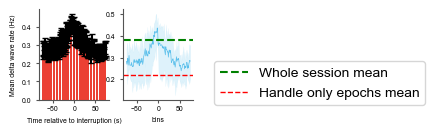

In [20]:
# Plot
fig = subjects.SdFig().fig1(8, 8)
ax = fig.subplot(fig.gs[0])
delta_rate = np.vstack(delta_rate)
mean_count = delta_rate.mean(axis=0)
std_count = delta_rate.std(axis=0) / np.sqrt(delta_rate.shape[0])

ax.bar(
    bins[:-1] + binsize / 2,
    delta_rate.mean(axis=0),
    yerr=std_count,
    # error_kw=dict(capsize=2),
    capsize=2,
    color=subjects.colors_sd(1)[1],
)

# ax.set_ylim(0.5)

ax.set_xlabel("Time relative to interruption (s)")
ax.set_ylabel("Mean delta wave rate (Hz)")

ax = fig.subplot(fig.gs[0,1])
delta_rate = np.vstack(delta_rate)
mean_count = delta_rate.mean(axis=0)
std_count = delta_rate.std(axis=0) / np.sqrt(delta_rate.shape[0])

sns.lineplot(data=delta_df, x="bins", y="rate", linewidth=0.5, err_kws={"linewidth":0.1}, ax=ax)
hwhole = ax.axhline(np.mean(delta_rate_whole), color='g', linestyle='--')
hhandle = ax.axhline(np.mean(delta_rate_handling), color='r', linestyle='--', linewidth=1)
ax.legend((hwhole, hhandle), ('Whole session mean', 'Handle only epochs mean'), bbox_to_anchor=(1.2, 0.5))
fig.savefig(subjects.figpath_sd / "handling_delta_rate", format="svg")

In [15]:
delta_rate_handling

[0.23416270617836174, 0.2791103603603604, 0.14369256474519632]